In [1]:
import torch  
import json 
from omegaconf import DictConfig, OmegaConf 
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 

from utils_pdhg import *


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_rehpdhg_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_rehpdhg_adamw/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_rehpdhg_adamw and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.0001, pdhg_iters=100, warm_start=False, lsqr_max_iter=1000
    momentum=False, diag_scaling=False, pd_type='pdhg', reflected_halpern=True, enable_restart=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 6.6797099113464355
In rank: 0, time taken for

In [3]:
with initialize(config_path="../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_rehpdhg_adamw/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_rehpdhg_adamw/bs-4-lr-0.001-wd-0/attn_rehpdhg_adamw-lr-0.001-constant-linear-fdeac8c7d1454187b9c83d9acf77e210.json


In [4]:
len(logger.pdhg_residuals[0])

4

In [5]:
logger.pdhg_residuals[0]['0'].keys()

dict_keys(['r1', 'r2', 'r1_rel', 'r2_rel', 'z_norm', 'y_norm', 'A1_norm', 'A2_norm', 'G1_norm', 'G2_norm', 'Y_norm'])

iteration=0


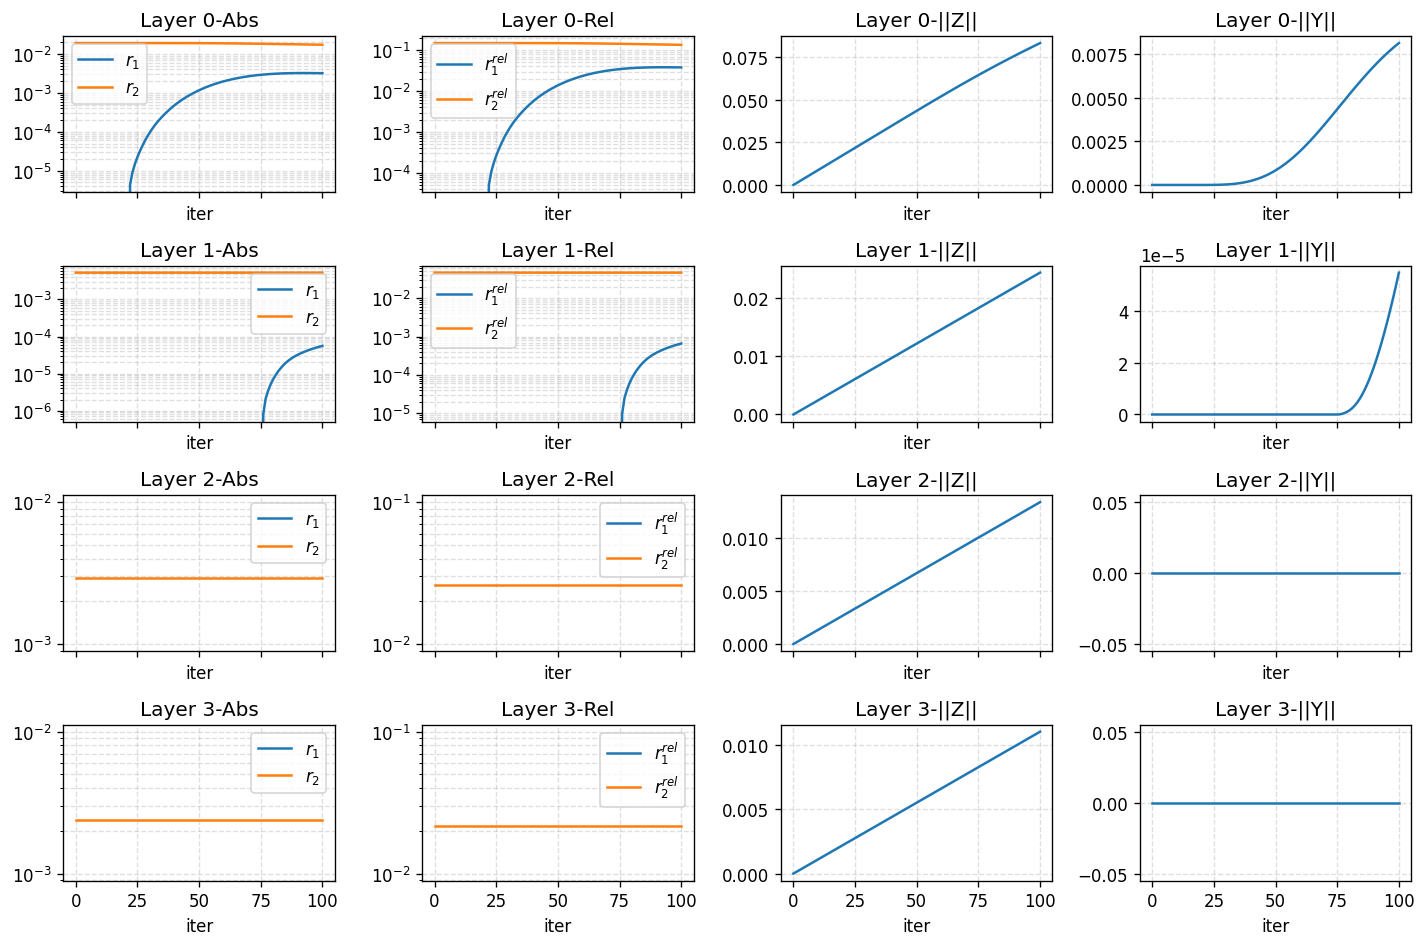

In [6]:
it = 0
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[0], dual_scale=False, agg_sum=False)

iteration=50


/mnt/home/tparshakova/Documents/GPT-opt/tests/utils_pdhg.py:622: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  a.set(yscale='log', title=f"Layer {layer}-{'Abs' if key == 'abs' else 'Rel'}", xlabel='iter')


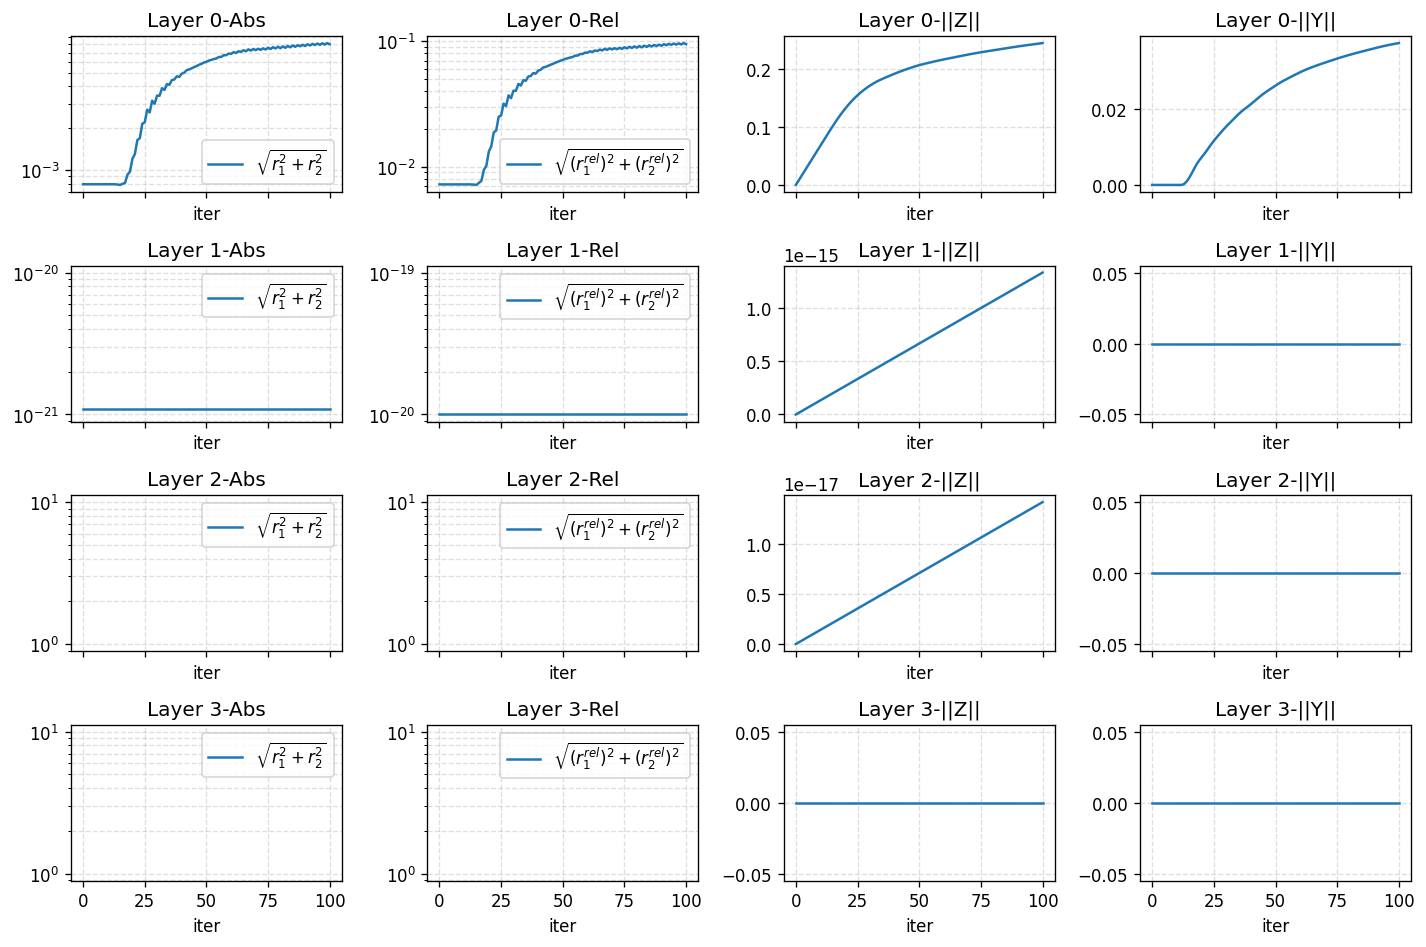

In [7]:
it = 50
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False, agg_sum=True)

iteration=100


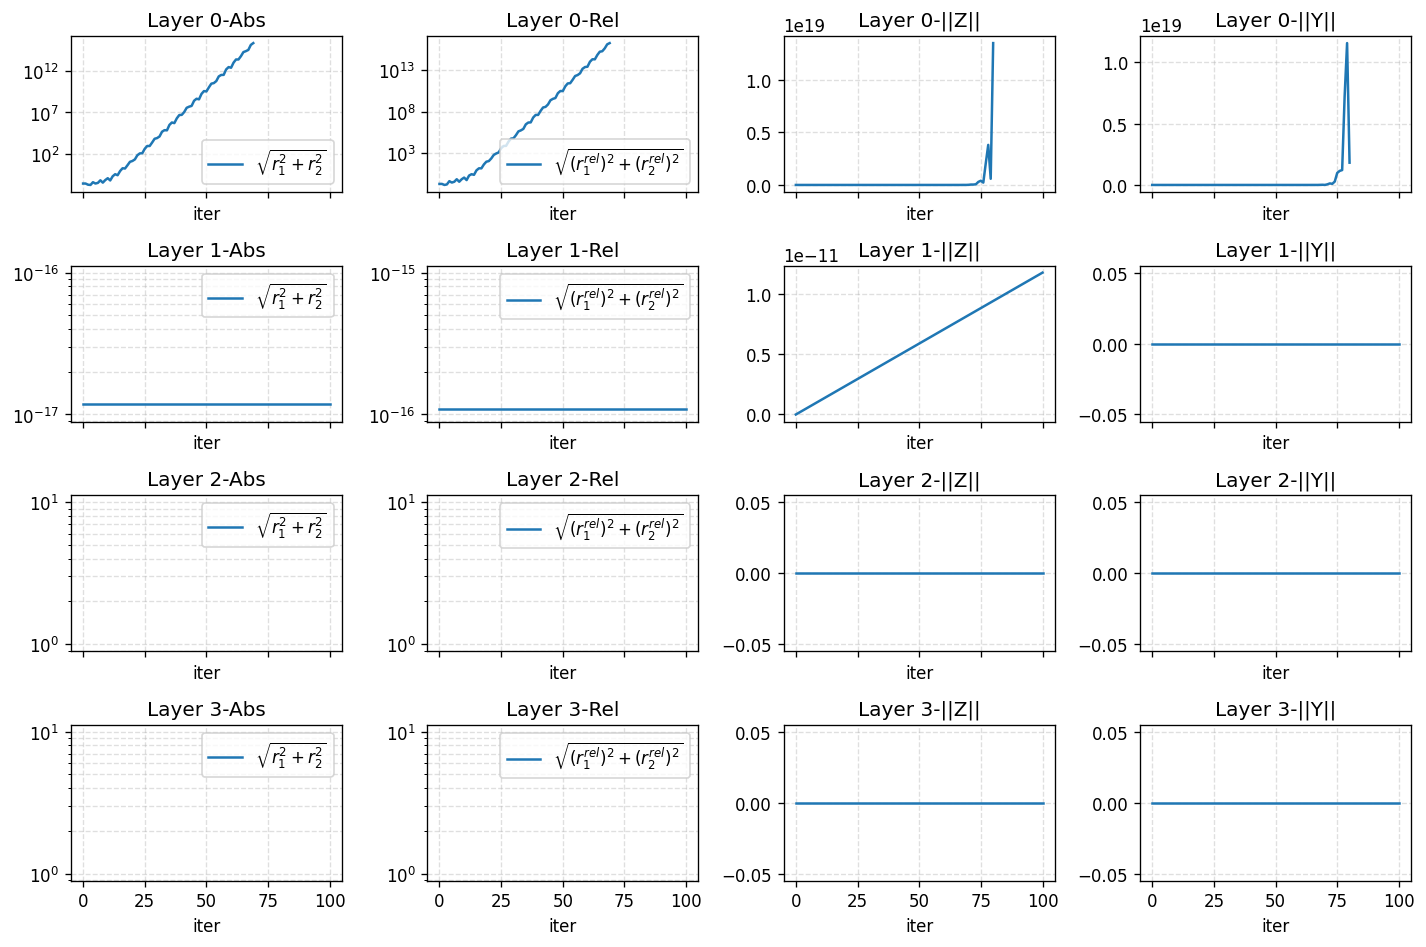

In [8]:
it = 100
print(f"iteration={it}")
plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False, agg_sum=True, dpi=120)

In [9]:
import pandas as pd

# First PDHG call (index 0)
it0 = logger.pdhg_residuals[-1]

# A1=W_q, A2=W_k
# G1=G_k, G2=G_q
rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx,
        "A1_norm": layer_res["A1_norm"],
        "A2_norm": layer_res["A2_norm"],
        "G2_norm": layer_res["G2_norm"],
        "G1_norm": layer_res["G1_norm"],
        "Y_norm": layer_res["Y_norm"], 
    })

df = pd.DataFrame(rows)
df

,layer,A1_norm,A2_norm,G2_norm,G1_norm,Y_norm
0,0,5.583133e-01,0.203368,2.116240e-01,7.518549e-02,1.140321
1,1,1.984780e-09,0.000100,1.984780e-13,1.003536e-08,0.000000
2,2,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
3,3,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
